In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.3 MB/s eta 0:00:00


In [ ]:
# Test mlflow

import mlflow

mlflow.set_tracking_uri("http://localhost:5000")

with mlflow.start_run():
    mlflow.log_param("param1", 15)
    mlflow.log_metric("metric1", 0.89)

🏃 View run luxuriant-fawn-133 at: http://localhost:5000/#/experiments/0/runs/0c4d48b8196f493ba0c136f2a4c20e71
🧪 View experiment at: http://localhost:5000/#/experiments/0


The `Connection refused` error in the previous cell indicates that the MLflow tracking server is not running. To fix this, you need to start the MLflow UI server. You can do this by running the following command in a new cell. Please note that `!mlflow ui` runs in the background and may require you to terminate the process if you want to stop it or run another command in the same cell after it.

In [ ]:
get_ipython().system_raw("mlflow ui --host 0.0.0.0 --port 5000 &")

# You can view the MLflow UI by clicking on 'Ports' in the left panel and then the 'Launch Port 5000' button.

After starting the MLflow UI, you can re-run the second cell to log your parameters and metrics.

In [ ]:
#creating baseline model

import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df= df[~(df['clean_comment'].str.strip() == '')]

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [ ]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [ ]:
df.head()

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [ ]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [ ]:
X
X.shape

(36793, 10000)

In [ ]:
y
y.shape

(36793,)

In [ ]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline")

2026/01/13 22:03:09 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1768341789439, experiment_id='1', last_update_time=1768341789439, lifecycle_stage='active', name='RF Baseline', tags={}>

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00


2026/01/13 22:07:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://localhost:5000/#/experiments/1/runs/15dcaf4e9f4946cfb20980f081a76c2f
🧪 View experiment at: http://localhost:5000/#/experiments/1
Accuracy: 0.6479141187661367


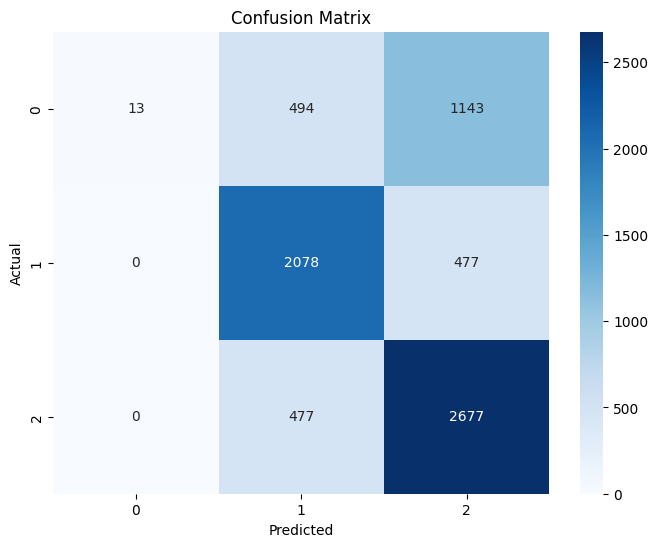

In [ ]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [ ]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [ ]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp 2 - BoW vs TfIdf")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [ ]:
df = pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

In [ ]:

# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")


In [ ]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp 3 - TfIdf Trigram max_features")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [ ]:
df = pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

In [ ]:
# Step 1: Function to run the experiment
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram setting

    # Step 2: Vectorization using TF-IDF with varying max_features
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_{max_features}")

# Step 6: Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)

In [ ]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-175-41-29.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp 4 - Handling Imbalanced Data")

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [ ]:
df = pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

In [ ]:
# Step 1: Function to run the experiment
def run_imbalanced_experiment(imbalance_method):
    ngram_range = (1, 3)  # Trigram setting
    max_features = 10000  # Set max_features to 1000 for TF-IDF

    # Step 4: Train-test split before vectorization and resampling
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    # Step 2: Vectorization using TF-IDF, fit on training data only
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
    X_test_vec = vectorizer.transform(X_test)  # Transform test data

    # Step 3: Handle class imbalance based on the selected method (only applied to the training set)
    if imbalance_method == 'class_weights':
        # Use class_weight in Random Forest
        class_weight = 'balanced'
    else:
        class_weight = None  # Do not apply class_weight if using resampling

        # Resampling Techniques (only apply to the training set)
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # Step 5: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_RandomForest_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, imbalance handling method={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalance_method)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        # Step 6: Make predictions and log metrics
        y_pred = model.predict(X_test_vec)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        confusion_matrix_filename = f"confusion_matrix_{imbalance_method}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_imbalance_{imbalance_method}")

# Step 7: Run experiments for different imbalance methods
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']

for method in imbalance_methods:
    run_imbalanced_experiment(method)


In [ ]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-196-109-131.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("Exp 5 - ML Algos with HP Tuning")

In [ ]:
import optuna
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.read_csv('/content/reddit_preprocessing.csv').dropna()
df.shape

In [ ]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
df = df.dropna(subset=['category'])

ngram_range = (1, 3)  # Trigram setting
max_features = 10000  # Set max_features to 1000 for TF-IDF

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
X_test_vec = vectorizer.transform(X_test)  # Transform test data

smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run():
        # Log model type
        mlflow.set_tag("mlflow.runName", f"{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")


# Step 6: Optuna objective function for XGBoost
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)

    model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    return accuracy_score(y_test, model.fit(X_train_vec, y_train).predict(X_test_vec))


# Step 7: Run Optuna for XGBoost, log the best model only
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=30)

    # Get the best parameters and log only the best model
    best_params = study.best_params
    best_model = XGBClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)

    # Log the best model with MLflow, passing the algo_name as "xgboost"
    log_mlflow("XGBoost", best_model, X_train_vec, X_test_vec, y_train, y_test)

# Run the experiment for XGBoost
run_optuna_experiment()


In [ ]:
!pip install mlflow boto3 awscli optuna imbalanced-learn lightgbm

In [ ]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-196-109-131.compute-1.amazonaws.com:5000/")

In [ ]:
# Set or create an experiment
mlflow.set_experiment("LightGBM HP Tuning")

In [ ]:
import pandas as pd

df = pd.read_csv('/content/reddit_preprocessing.csv').dropna()
df.shape

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import optuna
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 2: Remove rows where the target labels (category) are NaN
df = df.dropna(subset=['category'])

In [ ]:
# Step 3: TF-IDF vectorizer setup
ngram_range = (1, 3)  # Trigram
max_features = 1000  # Set max_features to 1000
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X = vectorizer.fit_transform(df['clean_comment'])
y = df['category']

# Step 4: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
# Function to log results in MLflow
def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        # Log model type and trial number
        mlflow.set_tag("mlflow.runName", f"Trial_{trial_number}_{model_name}_SMOTE_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")

        # Log algorithm name as a parameter
        mlflow.log_param("algo_name", model_name)

        # Log hyperparameters
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log the model
        mlflow.sklearn.log_model(model, f"{model_name}_model")

        return accuracy


In [ ]:
# Step 6: Optuna objective function for LightGBM
def objective_lightgbm(trial):
    # Hyperparameter space to explore
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)  # L1 regularization
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)  # L2 regularization

    # Log trial parameters
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }

    # Create LightGBM model
    model = LGBMClassifier(n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           num_leaves=num_leaves,
                           min_child_samples=min_child_samples,
                           colsample_bytree=colsample_bytree,
                           subsample=subsample,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           random_state=42)

    # Log each trial as a separate run in MLflow
    accuracy = log_mlflow("LightGBM", model, X_train, X_test, y_train, y_test, params, trial.number)

    return accuracy

In [ ]:
# Step 7: Run Optuna for LightGBM, log the best model, and plot the importance of each parameter
def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lightgbm, n_trials=100)  # Increased to 100 trials

    # Get the best parameters
    best_params = study.best_params
    best_model = LGBMClassifier(n_estimators=best_params['n_estimators'],
                                learning_rate=best_params['learning_rate'],
                                max_depth=best_params['max_depth'],
                                num_leaves=best_params['num_leaves'],
                                min_child_samples=best_params['min_child_samples'],
                                colsample_bytree=best_params['colsample_bytree'],
                                subsample=best_params['subsample'],
                                reg_alpha=best_params['reg_alpha'],
                                reg_lambda=best_params['reg_lambda'],
                                random_state=42)

    # Log the best model with MLflow and print the classification report
    log_mlflow("LightGBM", best_model, X_train, X_test, y_train, y_test, best_params, "Best")

    # Plot parameter importance
    optuna.visualization.plot_param_importances(study).show()

    # Plot optimization history
    optuna.visualization.plot_optimization_history(study).show()

In [ ]:
# Run the experiment for LightGBM
run_optuna_experiment()

In [ ]:
best_model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Load the dataset
dataset = pd.read_csv('/content/reddit_preprocessing.csv')

# Drop rows with NaN values in 'clean_comment'
cleaned_dataset = dataset.dropna()

# Separate features and target
X_cleaned = cleaned_dataset['clean_comment']
y_cleaned = cleaned_dataset['category']

# Split the cleaned data into train and test sets (80-20 split)
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Apply TfidfVectorizer with trigram setting and max_features=10000
tfidf_cleaned = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)

# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf_cleaned = tfidf_cleaned.fit_transform(X_train_cleaned)
X_test_tfidf_cleaned = tfidf_cleaned.transform(X_test_cleaned)

# Base learners
lightgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric="multi_logloss",
    is_unbalance=True,
    class_weight="balanced",
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization,
    learning_rate=0.08081298097796712,
    n_estimators=367,
    max_depth=20
)

logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', multi_class='multinomial')

# Meta-learner
knn_meta_learner = KNeighborsClassifier(n_neighbors=5)

# Create the StackingClassifier with LightGBM and LogisticRegression as base models, and KNN as meta-learner
stacking_model = StackingClassifier(
    estimators=[
        ('lightgbm', lightgbm_model),
        ('logistic_regression', logreg_model)
    ],
    final_estimator=knn_meta_learner,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train_tfidf_cleaned, y_train_cleaned)

# Make predictions on the test data
y_pred = stacking_model.predict(X_test_tfidf_cleaned)

# Generate classification report
print(classification_report(y_test_cleaned, y_pred))
